In [1]:
from Server_Cleaning.modules.Assignment_datasets import *
from Assignment_Queries.pandas_lib.std_imports import *
from Assignment_Queries.pandas_lib.func_lib import *

path = '../'

## age Analisys
We want to study players’ abilities based on their **age**. In particular, we will use players data and data on _'game events'_ to assess their performance.

In [2]:
p = get_players(path)[['player_id', 'name', 'date_of_birth']].dropna()
ge = get_game_events(path)[['date', 'type','player_id', 'description']].query('type != "Shootout" and type != "Substitutions"')

ge['description']= ge['description'].apply(lambda x : card_converter(x))

ge = ge.loc[ge['player_id'].isin(p['player_id'])]

# adding player_dob column
ge = ge.join(p[['player_id', 'date_of_birth']].set_index('player_id'), on='player_id')

ge = ge.apply(lambda x : fill_age(x), axis=1).rename(columns={'assist_player_birth':'assist_player_age', 'date_of_birth':'player_age'})
ge['date'] = pd.to_datetime(ge['date'].astype('string'))
lineplt = ge['player_age'].drop(columns=['player_id']).value_counts().sort_index()

## Distribution of Game Events
We've cleaned the dats about game_events and shown the distribution by the players' **ages**.  

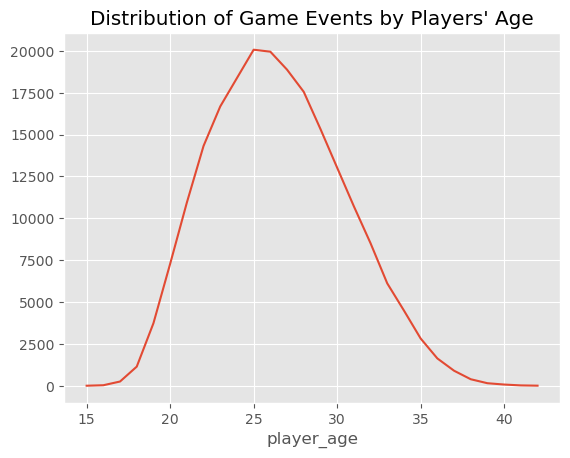

In [3]:
lineplt.plot(title='Distribution of Game Events by Players\' Age')

plt.show()

### Observation
You can clearly see how that the peak of events quantity is at 25 years old 

## Violin Plots
Now we will visualize the distribution of game events divided by cards and goals regarding players between 22 and 30 years old. We will also show the same graph, distinguishing cards by the typology 

In [4]:
#violin plot
''' 
    Wanna get a subsets of players which has a carrier from at least their 22s and to 30s and visualize the distribution of how many goals or cards they achieved/got 
'''
# filtering events and players with age in range
target_events = ge.query('(player_age >= 22 and player_age < 31)')
data_frames = target_events.drop(columns=['player_id']).reset_index(drop=True).rename(columns={ 'player_age':'age'})

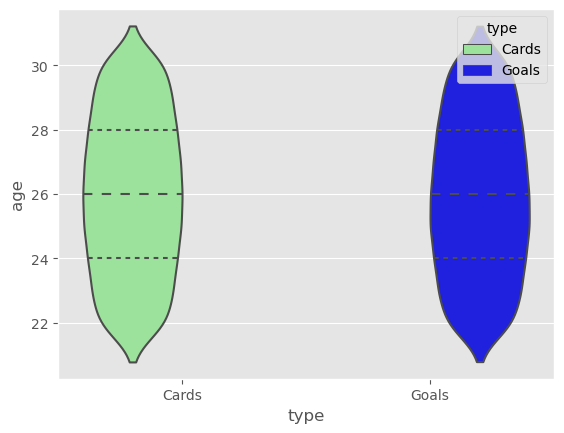

In [5]:
sns.violinplot(x= 'type',y='age',data= data_frames.query('description != "assist"'), bw = 0.25, hue='type',fill=False, palette={"Goals": "b", "Cards": "lightgreen"}, inner="quart" )

plt.show()

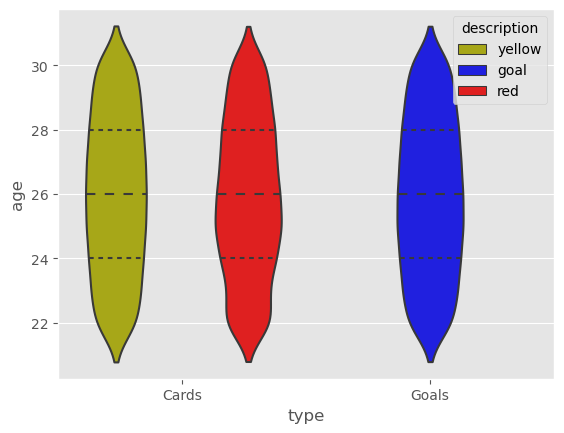

In [6]:
sns.violinplot(x='type', y='age', data=data_frames.query('description != "assist"'), bw=0.25, hue='description', fill=False, palette={"goal": "b", "yellow": 'y', "red": "r"}, inner="quart")

plt.show()

## Joint Plot
We chose to visualize the "goals" event types to study the density of events, watching the relation between the age of players and the event date. 
The target is to observe if the 'peak age' is changed through time.

In [7]:
ge_light = ge.loc[ge['player_age']>=0].loc[ge['description']!='assist'].drop(columns=['player_id']).reset_index(drop=True).rename(columns={'player_age':'age'})

C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\miniconda3\envs\geopandas_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

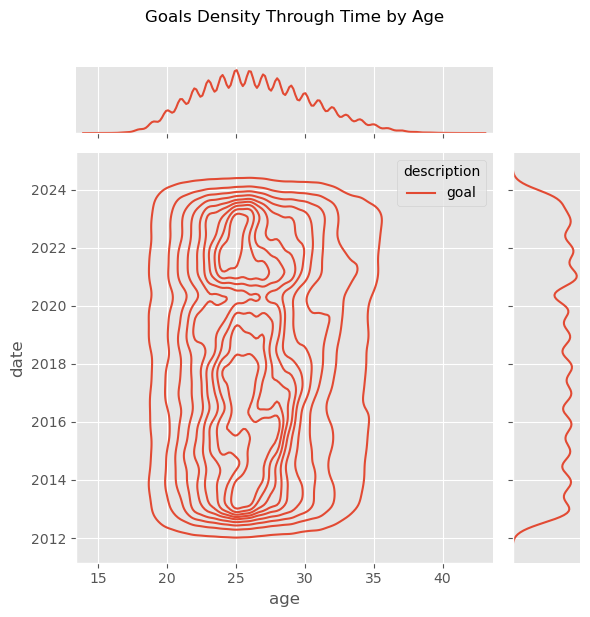

In [8]:
g = sns.jointplot(
    data=ge_light.query("type == 'Goals'"),
    x="age", y="date", hue="description",
    kind="kde"
)

plt.suptitle('Goals Density Through Time by Age', y=1.02)
plt.tight_layout()
plt.show()

### Observation
As you can see, around the 2020, there's a significant and general decrease of goals, probably caused by COVID19.

## Geopandas Chart
We decided to point out the differences about mean ages of players, active by 2022 to now days, between countries.
The next Chart will show which country has younger or older players

In [9]:
pl_vl = clear_player_valuations(get_player_valuations(path), get_competitions(path))
pl_vl = pl_vl.loc[pl_vl['player_id'].isin(p['player_id'])]

pl_vl = pl_vl.merge(p[['player_id', 'date_of_birth']], on='player_id', how='left').drop(columns=['market_value_eur', 'player_id'])

pl_vl['age'] = pd.to_datetime(pl_vl['date_of_birth'].astype('string')).apply(lambda x: (pd.Timestamp.now().year - x.year))
pl_vl = pl_vl.drop(columns=['date_of_birth'])

# Merging Scotland values with England value, due to the use of 'europe.topojson' file 
pl_vl['country_name'].replace('Scotland','England', inplace=True)

pl_vl = pl_vl.groupby('country_name', as_index=False).agg(mean=pd.NamedAgg('age', 'mean')).replace('England','United Kingdom')

# Merging the data of the .topojson with our dataset
europe_gdf = gpd.read_file(path + 'Assignment_Queries/country_topography/europe.topojson')
geo_data = europe_gdf.merge(pl_vl, left_on='NAME', right_on='country_name', how='left')
geo_data['mean'] = geo_data['mean'].fillna(0)

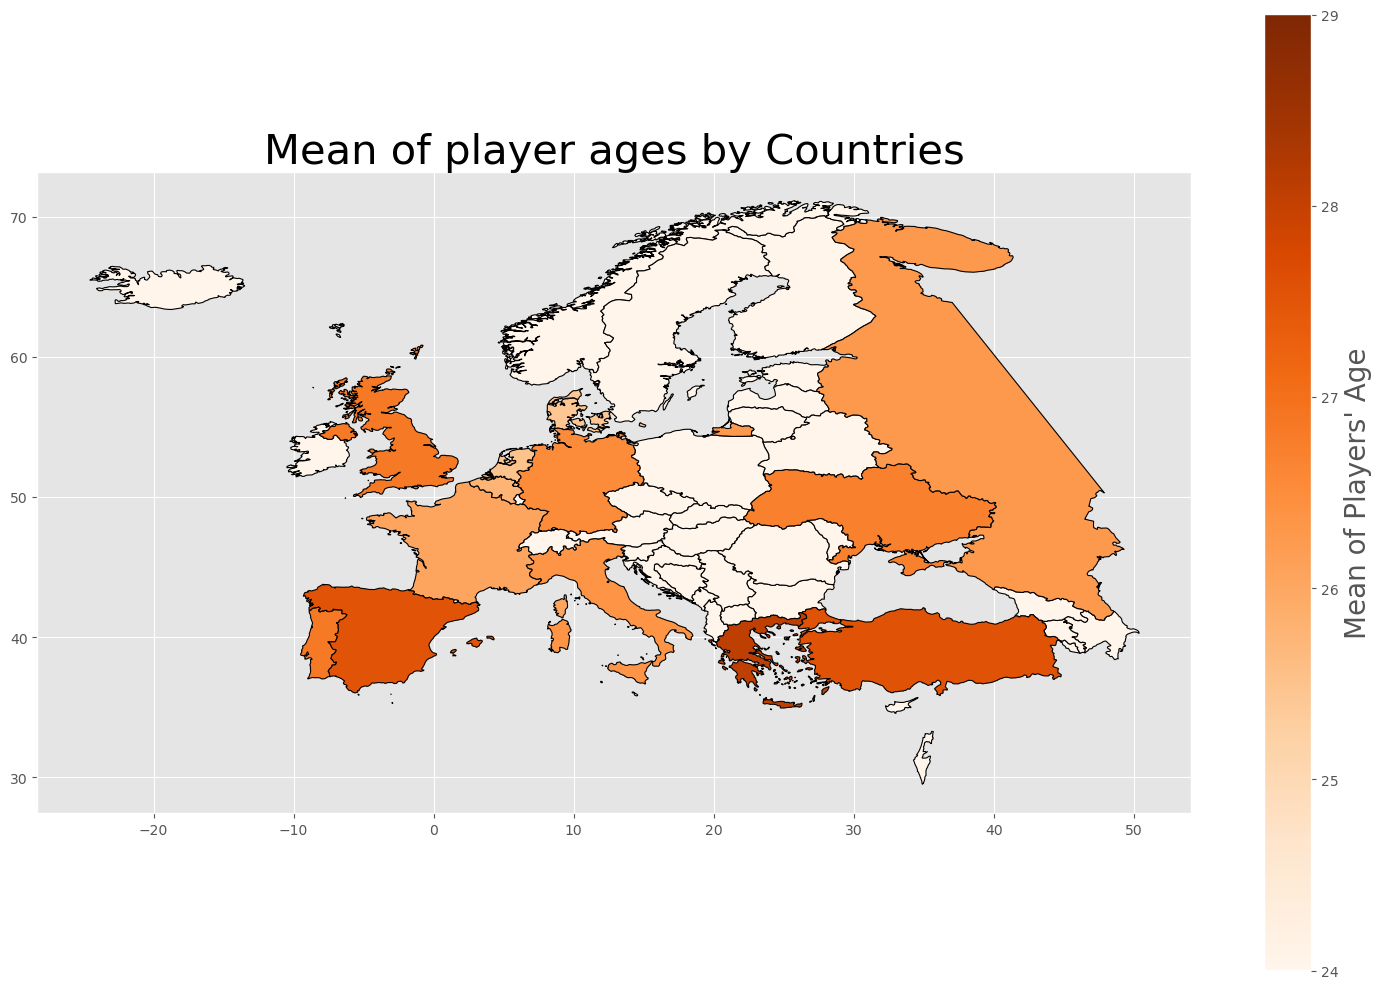

In [10]:
ax = geo_data.plot(figsize=(15,10), edgecolor='black', cmap='Oranges', linewidth=0.8, column='mean', legend=True, vmin=24, vmax=29)
ax.set_title('Mean of player ages by Countries', fontsize='30')

colorbar_ax = ax.get_figure().axes[-1]
colorbar_ax.set_ylabel('Mean of Players\' Age', fontsize='20')

plt.tight_layout()
plt.show()